# 01_EDA – Análisis Exploratorio de Datos  
Este notebook corresponde a la fase **Data Understanding** del enfoque CRISP-DM.

Se abordarán tres bloques de análisis:
- **Top‑Down** (total → familia)
- **Bottom‑Up** (SKU → patrón)
- **Intermitencia**

Los archivos de entrada provienen de tres fuentes tabulares, y el campo `periodo` será tratado como texto para evitar errores en visualizaciones temporales.


### Librerías y rutas de trabajo

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact

# Rutas
DATA_PATH = r"C:\Developer\Laboratorio_III\data"
SELL_IN_FILE = DATA_PATH + r"\sell-in.txt"
PRODUCT_FILE = DATA_PATH + r"\tb_productos.txt"
STOCK_FILE = DATA_PATH + r"\tb_stocks.txt"


### Carga de archivos y verificación del campo `periodo`

In [3]:

def load_txt(path, **kwargs):
    return pd.read_csv(path, sep="\t", engine="python", **kwargs)

df_sales = load_txt(SELL_IN_FILE)
df_prod = load_txt(PRODUCT_FILE)
df_stock = load_txt(STOCK_FILE)

# Asegurar que 'periodo' sea string
for df in [df_sales, df_stock]:
    df['periodo'] = df['periodo'].astype(str)

display(df_sales.head(), df_prod.head(), df_stock.head())


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


### Estructura de los datasets

In [4]:

for nombre, df in [('Ventas', df_sales), ('Productos', df_prod), ('Stocks', df_stock)]:
    print(f"\n── {nombre} ──")
    display(df.info())
    display(df.isna().mean().rename('%NA'))



── Ventas ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                object 
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 157.3+ MB


None

periodo                  0.0
customer_id              0.0
product_id               0.0
plan_precios_cuidados    0.0
cust_request_qty         0.0
cust_request_tn          0.0
tn                       0.0
Name: %NA, dtype: float64


── Productos ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat1        1262 non-null   object
 1   cat2        1262 non-null   object
 2   cat3        1262 non-null   object
 3   brand       1262 non-null   object
 4   sku_size    1262 non-null   int64 
 5   product_id  1262 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 59.3+ KB


None

cat1          0.0
cat2          0.0
cat3          0.0
brand         0.0
sku_size      0.0
product_id    0.0
Name: %NA, dtype: float64


── Stocks ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  object 
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 321.0+ KB


None

periodo        0.0
product_id     0.0
stock_final    0.0
Name: %NA, dtype: float64

### Dataset Integrado (`df_all`)

In [5]:

df_all = (
    df_sales
    .merge(df_prod, on='product_id', how='left')
    .merge(df_stock, on=['product_id', 'periodo'], how='left')
)

df_all = df_all.sort_values(['periodo', 'product_id'])
df_all.to_parquet(DATA_PATH + r"\dataset_integrado.parquet")
df_all.head()


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
44144,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
44145,201701,10063,20001,0,1,0.12312,0.12312,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
44146,201701,10080,20001,0,1,0.24625,0.24625,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
44147,201701,10094,20001,0,1,1.23123,1.23123,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
44148,201701,10184,20001,0,1,0.06716,0.06716,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN


## Análisis Top‑Down: Ventas por familia a lo largo del tiempo

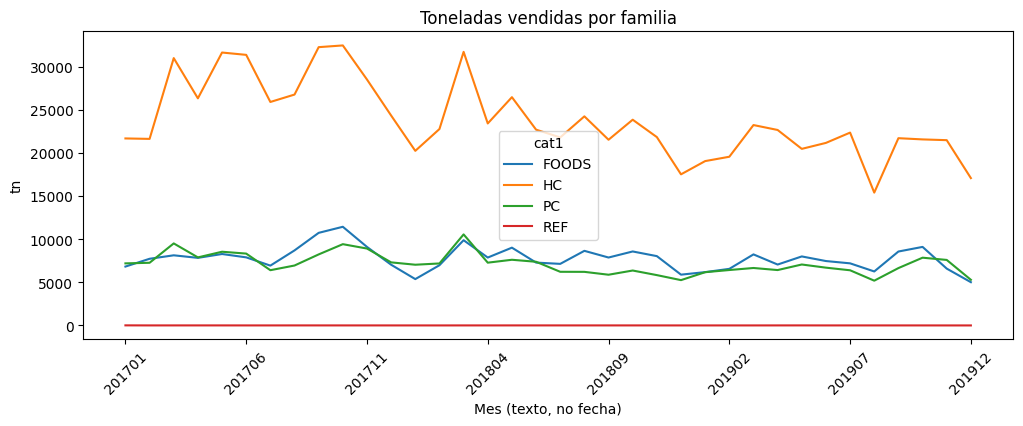

interactive(children=(Dropdown(description='familia', index=1, options=('FOODS', 'HC', 'PC', 'REF'), value='HC…

In [ ]:

agg_family = (
    df_all.groupby(['periodo', 'cat1'], observed=True)['tn']
    .sum()
    .reset_index()
)

pivot = agg_family.pivot(index='periodo', columns='cat1', values='tn')
pivot.plot(figsize=(12, 4))
plt.title('Toneladas vendidas por familia')
plt.ylabel('tn')
plt.xlabel('Mes (texto, no fecha)')
plt.xticks(rotation=45)
plt.show()

@interact(familia=sorted(df_all['cat1'].dropna().unique()))
def zoom_familia(familia='HC'):
    ts = pivot[familia]
    ts.plot(figsize=(10, 3))
    plt.title(f'Ventas de la familia {familia}')
    plt.ylabel('tn')
    plt.xticks(rotation=45)
    plt.show()


## Top‑Down: Clientes con mayor volumen total

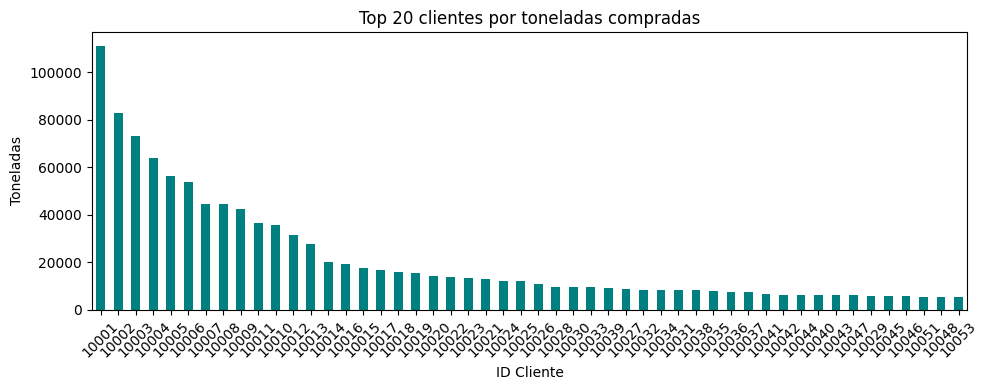

In [35]:

# Clientes con mayor volumen total
clientes_top = df_all.groupby('customer_id')['tn'].sum().sort_values(ascending=False).head(50)

clientes_top.plot(kind='bar', figsize=(10,4), color='teal')
plt.title('Top 20 clientes por toneladas compradas')
plt.ylabel('Toneladas')
plt.xlabel('ID Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis Bottom‑Up  
Ahora partimos de cada **SKU** para caracterizar la importancia (ABC) y la volatilidad (XYZ) de la demanda. Esto orientará la selección de modelos por tipo de serie.

,total_tn,cum_pct,ABC,XYZ
product_id,,,,
20001,50340.39558,0.036081,A,Z
20010,37342.15836,0.062845,A,Z
20002,36337.25439,0.088889,A,Z
20003,32004.15274,0.111827,A,Z
20021,25003.78252,0.129748,A,Z


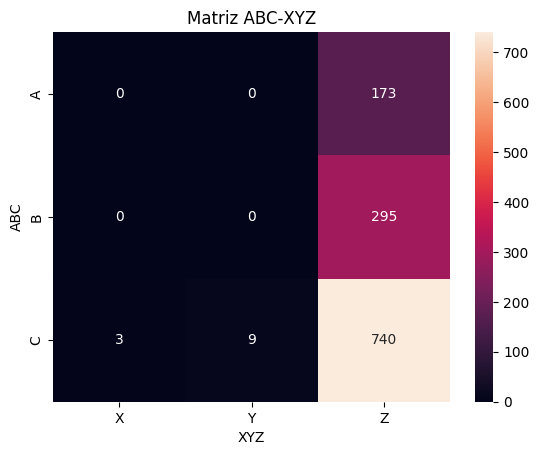

In [30]:

# ABC basado en contribución acumulada a las ventas totales
sku_tot = df_all.groupby('product_id')['tn'].sum().sort_values(ascending=False)
cum_pct = sku_tot.cumsum() / sku_tot.sum()
abc_class = pd.cut(cum_pct, bins=[0, .8, .95, 1], labels=list('ABC'))
abc_df = pd.DataFrame({'total_tn': sku_tot, 'cum_pct': cum_pct, 'ABC': abc_class})

# XYZ usando Coeficiente de Variación de la demanda mensual
def cov(series):
    mean = series.mean()
    return np.nan if mean == 0 else series.std()/mean

cov_vals = df_all.groupby('product_id')['tn'].apply(cov)
xyz_class = pd.cut(cov_vals, bins=[-np.inf, .5, 1, np.inf], labels=list('XYZ'))
abc_df['XYZ'] = xyz_class

display(abc_df.head())

# Heatmap ABC‑XYZ
matrix = pd.crosstab(abc_df['ABC'], abc_df['XYZ'])
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Matriz ABC‑XYZ')
plt.show()


# Visualización extendida del análisis ABC-XYZ

En esta sección generamos dos herramientas visuales para entender mejor la relación entre volumen de ventas y volatilidad:

1. Un gráfico de dispersión (scatter plot) con los SKUs según sus toneladas vendidas y su Coeficiente de Variación.
2. Un ranking de los SKUs con mayor dificultad de modelado (alto CV + alto volumen), para enfocar esfuerzos de predicción.

Ambas visualizaciones ayudarán a tomar decisiones tácticas sobre qué productos priorizar.


## Gráfico de dispersión: Ventas vs. Volatilidad (CV)
Visualizamos cada SKU según su volumen total de toneladas (eje X) y su Coeficiente de Variación (CV) de demanda mensual (eje Y).
Coloreamos según la clasificación ABC para observar patrones.

In [12]:

# Dataset df_all ya debe estar cargado
df_total_tn = df_all.groupby('product_id')['tn'].sum().sort_values(ascending=False)
cum_pct = df_total_tn.cumsum() / df_total_tn.sum()
abc_class = pd.cut(cum_pct, bins=[0, 0.8, 0.95, 1.0], labels=['A', 'B', 'C'])

# CV por SKU
df_cv = df_all.groupby('product_id')['tn'].apply(lambda x: x.std() / x.mean() if x.mean() != 0 else None)

# Dataset combinado
df_stats = pd.concat([df_total_tn.rename("total_tn"), df_cv.rename("cv"), abc_class.rename("ABC")], axis=1).dropna()

# Gráfico de dispersión
fig = px.scatter(df_stats, x="total_tn", y="cv", color="ABC",
                 hover_name=df_stats.index.astype(str),
                 log_x=True,
                 title="Dispersión: Volumen total vs. Volatilidad (CV)",
                 labels={"total_tn": "Toneladas Totales (log)", "cv": "Coef. Variación"})
fig.show()



## Ranking de SKUs difíciles de modelar
Listamos los SKUs que combinan **alto volumen** con **alta volatilidad**, ordenados por el producto `total_tn * CV`. Estos productos son estratégicamente importantes, pero muy inestables, por lo que deben tener prioridad en el modelado.

In [11]:

# Score = volumen * variabilidad
df_stats['dificultad'] = df_stats['total_tn'] * df_stats['cv']
ranking = df_stats.sort_values('dificultad', ascending=False).head(15)

ranking.reset_index().rename(columns={'product_id': 'SKU'})


,SKU,total_tn,cv,ABC,dificultad
0,20001,50340.39558,3.896009,A,196126.618564
1,20002,36337.25439,4.018330,A,146015.090288
2,20003,32004.15274,3.305343,A,105784.715205
3,20010,37342.15836,2.598164,A,97021.040783
4,20005,23191.21852,3.132942,A,72656.745274
5,20007,22018.45234,3.176768,A,69947.522368
6,20021,25003.78252,2.665668,A,66651.793876
7,20004,24178.15379,2.599093,A,62841.267238
8,20020,24516.78008,2.538552,A,62237.122051
9,20014,16177.73435,3.802383,A,61513.940728


### Intermitencia de la demanda  
Evaluamos qué tan frecuentes son las ventas por SKU (0 = ventas todos los meses, 1 = nunca). Series muy intermitentes requerirán técnicas específicas (p.ej., Croston).

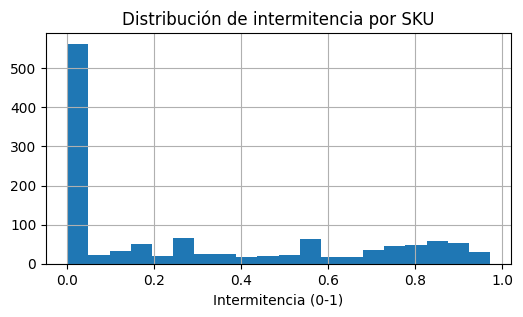

In [8]:

# Matriz periodo × SKU
sku_mat = df_all.pivot_table(index='periodo', columns='product_id', values='tn', fill_value=0)

def intermittency(series):
    return 1 - (series > 0).sum() / len(series)

interm_values = sku_mat.apply(intermittency).sort_values()

interm_values.hist(bins=20, figsize=(6,3))
plt.title('Distribución de intermitencia por SKU')
plt.xlabel('Intermitencia (0‑1)')
plt.show()


## Bottom‑Up: Evolución mensual de cada cliente (interactivo)

In [ ]:

# Tabla de toneladas por mes y cliente
pivot_clientes = df_all.pivot_table(index='periodo', columns='customer_id', values='tn', aggfunc='sum', fill_value=0)

@interact(cliente=sorted(pivot_clientes.columns))
def grafico_cliente(cliente):
    pivot_clientes[cliente].plot(figsize=(10,3))
    plt.title(f'Evolución mensual de compras - Cliente {cliente}')
    plt.ylabel('Toneladas')
    plt.xlabel('Periodo')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='cliente', options=(10001, 10002, 10003, 10004, 10005, 10006, 10007…

## Estabilidad de compras: ¿Qué tan constantes son los clientes?

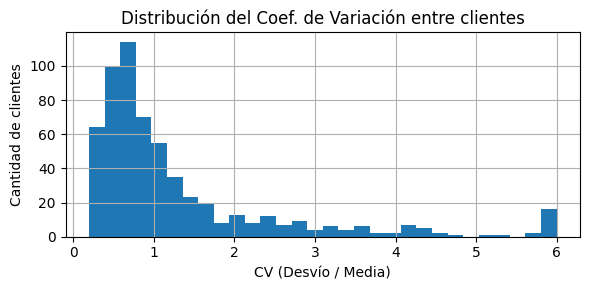

In [32]:

# Coeficiente de variación por cliente
cv_clientes = pivot_clientes.std() / pivot_clientes.mean()
cv_clientes = cv_clientes.replace([np.inf, -np.inf], np.nan).dropna()

cv_clientes.hist(bins=30, figsize=(6,3))
plt.title('Distribución del Coef. de Variación entre clientes')
plt.xlabel('CV (Desvío / Media)')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# Pivot de toneladas por periodo y cliente
pivot_clientes = df_all.pivot_table(index='periodo', columns='customer_id', values='tn', aggfunc='sum', fill_value=0)

# Coeficiente de variación por cliente
cv_clientes = pivot_clientes.std() / pivot_clientes.mean()
cv_clientes = cv_clientes.replace([np.inf, -np.inf], np.nan).dropna()

# Volumen total por cliente
volumen_clientes = pivot_clientes.sum()

# Dataset combinado
df_clientes = pd.DataFrame({
    'total_tn': volumen_clientes,
    'cv': cv_clientes
}).dropna()

# Gráfico de dispersión interactivo
fig = px.scatter(df_clientes,
                 x='total_tn',
                 y='cv',
                 hover_name=df_clientes.index.astype(str),
                 log_x=True,
                 labels={'total_tn': 'Toneladas totales (log)', 'cv': 'Coef. Variación'},
                 title='Dispersión: Volumen total vs. Variabilidad de compras (clientes)',
                 height=500)

fig.show()


## Preferencias por familia de producto (`cat1`)

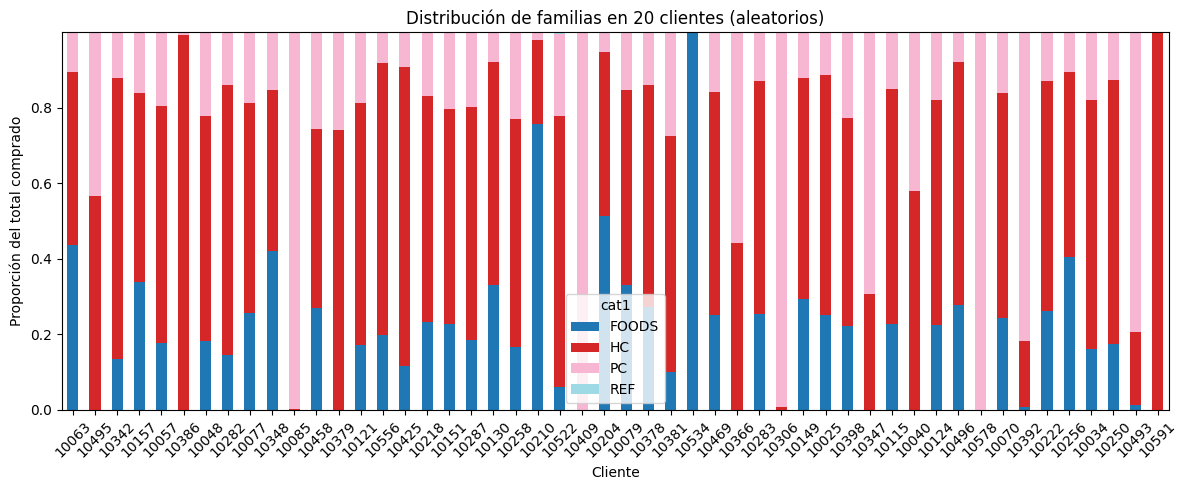

In [34]:

# Top clientes por familia
df_familia = df_all.groupby(['customer_id', 'cat1'])['tn'].sum().reset_index()
pivot_familia = df_familia.pivot(index='customer_id', columns='cat1', values='tn').fillna(0)

pivot_familia_norm = pivot_familia.div(pivot_familia.sum(axis=1), axis=0)  # normalizar

pivot_familia_norm.sample(50).plot(kind='bar', stacked=True, figsize=(12,5), colormap='tab20')
plt.title('Distribución de familias en 20 clientes (aleatorios)')
plt.ylabel('Proporción del total comprado')
plt.xlabel('Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Resumen de hallazgos preliminares  
Guardamos un *diccionario* con métricas clave del dataset para referencia rápida.

In [9]:

resumen = {
    'total_skus': df_prod['product_id'].nunique(),
    'rango_periodo': (df_all['periodo'].min(), df_all['periodo'].max()),
    'intermitencia_media': interm_values.mean()
}
resumen


{'total_skus': 1251,
 'rango_periodo': ('201701', '201912'),
 'intermitencia_media': 0.2961385960169415}

## Próximos pasos  
- **Ingeniería de variables temporales** (lags, ventanas móviles, flags de lanzamientos).
- Dividir en *train/test* con ventanas deslizantes (horizonte +2).
- Benchmark inicial con modelos **Naïve** y **ETS** para establecer línea base.